# Importing the required Libraries

In [1]:
from typing import Callable
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from scipy.integrate import solve_ivp
import numpy as np
import scipy.io
import time
import urllib
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from functools import partial


# Checking for GPU access
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\chetanm\.conda\envs\pytorch-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda:0


# Data Preprocessing

In [2]:
# Boundary points from subdomian 1
N_ub = 500

# Residual points in three subdomains
N_f1 = 500
N_f2 = 500

# Interface points along the two interfaces
N_I1 = 400

# Load training data (boundary points), residual and interface points from .mat file
# All points are generated in Matlab
main_folder_path = Path('.')
data = scipy.io.loadmat(main_folder_path / 'matlab_500_full.mat')

# Data Preprocessing
x_f1 = data['x_domain'].flatten()[:, None]
y_f1 = data['y_domain'].flatten()[:, None]
x_f2 = data['x_coil'].flatten()[:, None]
y_f2 = data['y_coil'].flatten()[:, None]

x_i = data['x_i'].flatten()[:, None]
y_i = data['y_i'].flatten()[:, None]

x_boundary = data['x_boundary'].flatten()[:, None]
y_boundary = data['y_boundary'].flatten()[:, None]

u_boundary = data['u_boundary'].flatten()[:, None]
u_exact1 = data['u_domain'].flatten()[:, None]
u_exact2 = data['u_coil'].flatten()[:, None]
u_exacti = data['u_i'].flatten()[:, None]

u_exact = np.concatenate([u_exact1, u_exact2, u_exacti, u_boundary])

u_exact1 = np.divide(u_exact1, u_exact.max())
u_exact2 = np.divide(u_exact2, u_exact.max())
u_exacti = np.divide(u_exacti, u_exact.max())
u_boundary = np.divide(u_boundary, u_exact.max())

X_f1 = np.hstack((x_f1.flatten()[:, None], y_f1.flatten()[:, None]))
X_f2 = np.hstack((x_f2.flatten()[:, None], y_f2.flatten()[:, None]))
X_fi = np.hstack((x_i.flatten()[:, None], y_i.flatten()[:, None]))
X_ub = np.hstack((x_boundary.flatten()[:, None], y_boundary.flatten()[:, None]))

# Randomly select the residual points from sub-domains
idx1 = np.random.choice(X_f1.shape[0], N_f1, replace=False)
X_f1_train = np.float32(X_f1[idx1, :])
u_f1_train = np.float32(u_exact1[idx1, :])

idx2 = np.random.choice(X_f2.shape[0], N_f2, replace=False)
X_f2_train = np.float32(X_f2[idx2, :])
u_f2_train = np.float32(u_exact2[idx2, :])

# Randomly select boundary points
idx4 = np.random.choice(X_ub.shape[0], N_ub, replace=False)
X_ub_train = np.float32(X_ub[idx4, :])
ub_train = np.float32(u_boundary[idx4, :])

# Randomly select the interface points along two interfaces
idxi1 = np.random.choice(X_fi.shape[0], N_I1, replace=False)
X_fi_train = np.float32(X_fi[idxi1, :])
u_fi1_train = np.float32(u_exacti[idxi1, :])

# Defining the Model

In [4]:
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Sigmoid(), scaling_factor=20):

        super().__init__()

        self.layer_in = nn.Linear(2, dim_hidden)
        self.layer_before_out = nn.Linear(dim_hidden, 100) 
        self.layer_out = nn.Linear(100, 1)        
        self.A = nn.Parameter(0.05*torch.ones(1,num_hidden,), requires_grad=True)
        self.scaling_factor = scaling_factor
        self.act = act

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )        
        

    def forward(self, x):
        out = self.act(self.scaling_factor*self.A[0, 0]*self.layer_in(x))
        for i, layer in enumerate(self.middle_layers):
            out = self.act(self.scaling_factor*self.A[0, i + 1]*layer(out))
        
        out = self.act(self.layer_before_out(out))
        
        if (self.act == nn.Tanh()): 
          return self.layer_out(out)
        else:
          return self.act(self.layer_out(out))
    

def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def df(nn: NNApproximator, x: torch.Tensor = None, y: torch.Tensor = None, diff: torch.Tensor = None, order: int = 2) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(nn, torch.cat((x, y), dim=1))

    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            diff,
            grad_outputs = torch.ones_like(df_value),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value

def df_2(nn: NNApproximator, df_value: torch.Tensor = None, diff: torch.Tensor = None, order: int = 2) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            diff,
            # grad_outputs=torch.ones(output_dim),
            grad_outputs = torch.ones_like(df_value),
            # grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value

def compute_loss(
    nn1: NNApproximator, 
    nn2: NNApproximator, 
    epoch : int = 0,
    x1: torch.Tensor = None, 
    x2: torch.Tensor = None, 
    xi: torch.Tensor = None, 
    xb: torch.Tensor = None, 
    ub: torch.Tensor = None,
    ufi: torch.Tensor = None,
    u1: torch.Tensor = None,
    u2: torch.Tensor = None,
    mult: int = 1,
    verbose: bool = False
) -> torch.float:

    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    multiplier = mult
    mu_0 = 1
    
    # Separating the X and Y coordinates
    x_d1 = x1[:, 0:1]
    y_d1 = x1[:, 1:2]
    x_d2 = x2[:, 0:1]
    y_d2 = x2[:, 1:2]
    x_i = xi[:, 0:1]
    y_i = xi[:, 1:2]
        
    # Interior Losses
    # Non-Linear Material
    grad_Ax_1 = df(nn1, x_d1, y_d1, x_d1, order=1)
    grad_Ay_1 = df(nn1, x_d1, y_d1, y_d1, order=1)
    grad_A = torch.add(torch.square(grad_Ax_1), torch.square(grad_Ay_1))
    grad_A = torch.mul(grad_A, 0.05)
    grad_A = torch.add(grad_A, 1)
    mu_r = torch.div(5000, grad_A)
    mu_r = torch.add(mu_r, 200)
    mu = torch.mul(mu_r, mu_0)
    mu_reciprocal = torch.div(1, grad_A)
    
    grad_Ax_1 = torch.mul(grad_Ax_1, mu_reciprocal)
    grad_Ay_1 = torch.mul(grad_Ay_1, mu_reciprocal)
    
    Ax_1 = df_2(nn1, grad_Ax_1, x_d1, order=1)
    Ay_1 = df_2(nn1, grad_Ay_1, y_d1, order=1)
    
    # Linear Material
    interior_loss_1 = torch.add(Ax_1, Ay_1)
    
    Ax_2 = df(nn2, x_d2, y_d2, x_d2, order=2)
    Ay_2 = df(nn2, x_d2, y_d2, y_d2, order=2)
    interior_loss_2 = torch.sub(torch.add(Ax_2, Ay_2), -1)

    # Interface Loss
    u1_i = f(nn1, xi)
    u2_i = f(nn2, xi)
    uAvg_i = torch.div(torch.add(u1_i, u2_i), 2)
    interface_loss_1 = torch.sub(uAvg_i, u1_i)
    interface_loss_2 = torch.sub(uAvg_i, u2_i)

    actual_interface_loss_1 = torch.sub(ufi, u1_i)
    actual_interface_loss_2 = torch.sub(ufi, u2_i)

    # Interface
    # Non-Linear Material
    grad_Ax_i1 = df(nn1, x_i, y_i, x_i, order=1)
    grad_Ay_i1 = df(nn1, x_i, y_i, y_i, order=1)
    grad_A = torch.add(torch.square(grad_Ax_i1), torch.square(grad_Ay_i1))
    grad_A = torch.mul(grad_A, 0.05)
    grad_A = torch.add(grad_A, 1)
    mu_r = torch.div(5000, grad_A)
    mu_r = torch.add(mu_r, 200)
    mu = torch.mul(mu_r, mu_0)
    mu_reciprocal = torch.div(1, grad_A)
    
    grad_Ax_i1 = torch.mul(grad_Ax_i1, mu_reciprocal)
    grad_Ay_i1 = torch.mul(grad_Ay_i1, mu_reciprocal)
    
    Ax_i1 = df_2(nn1, grad_Ax_i1, x_i, order=1)
    Ay_i1 = df_2(nn1, grad_Ay_i1, y_i, order=1)    
    
    # Linear Mat
    interface_1 = torch.add(Ax_i1, Ay_i1)
    
    Ax_i2 = df(nn2, x_i, y_i, x_i, order=2)
    Ay_i2 = df(nn2, x_i, y_i, y_i, order=2)
    interface_2 = torch.add(Ax_i2, Ay_i2)

    # Residual Continuity conditions on the interfaces
    res_loss_1 = torch.sub(interface_1, torch.sub(interface_2, -1))
    res_loss_2 = torch.sub(interface_1, torch.sub(interface_2, -1))
    
    # Boundary Loss
    ub_pred = f(nn1, xb)
    boundary_loss = torch.sub(ub, ub_pred)
        
    
    if epoch % 2000 == 0:

      print(f"Loss at {epoch}: {interior_loss_1.pow(2).mean()}, {interface_loss_1.pow(2).mean()}, \
              domain: {interior_loss_2.pow(2).mean()}, {interface_loss_2.pow(2).mean()}, {boundary_loss.pow(2).mean()}")

    loss_1 = \
        interior_loss_1.pow(2).mean() + \
        multiplier * boundary_loss.pow(2).mean() + \
        multiplier * interface_loss_1.pow(2).mean() + \
        multiplier * actual_interface_loss_1.pow(2).mean() #+ \
#         res_loss_1.pow(2).mean() #+ \
#         dom_loss_1.pow(2).mean()

    loss_2 = \
        interior_loss_2.pow(2).mean() + \
        multiplier * interface_loss_2.pow(2).mean() + \
        multiplier * actual_interface_loss_2.pow(2).mean() #+ \
#         res_loss_2.pow(2).mean() #+ \
#         dom_loss_2.pow(2).mean()

    final_loss = loss_1 + loss_2

    loss_list = [interior_loss_1.pow(2).mean().detach().cpu().numpy(), 
              interface_loss_1.pow(2).mean().detach().cpu().numpy(), 
              interior_loss_2.pow(2).mean().detach().cpu().numpy(), 
              interface_loss_2.pow(2).mean().detach().cpu().numpy(), 
              boundary_loss.pow(2).mean().detach().cpu().numpy()]

    return final_loss, loss_list


def train_model(
    nn1: NNApproximator, 
    nn2: NNApproximator, 
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1000,
):

    loss_evolution_1, loss_evolution_2 = [], []
    interior_loss_1, interface_loss_1, interior_loss_2, interface_loss_2, boundary_loss= [], [], [], [], []

    
    optimizer = torch.optim.NAdam([
                {'params': nn1.parameters(), 'lr': learning_rate},
                {'params': nn2.parameters(), 'lr': learning_rate}
            ])
    
  
    for epoch in range(max_epochs):

        try:
            loss, loss_list = loss_fn(nn1, nn2, epoch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss # 1: {float(loss):>7f}")
                
                # Solution prediction
                nn1_trained = nn1
                nn2_trained = nn2

                device = torch.device("cpu")
                nn1_trained.to(device)
                nn2_trained.to(device)
            
                u_pred1 = nn1_trained(torch.tensor(np.float32(X_f1))).detach().cpu().numpy()
                u_pred2 = nn2_trained(torch.tensor(np.float32(X_f2))).detach().cpu().numpy()

                u_pred_i1 = nn1_trained(torch.tensor(np.float32(X_fi))).detach().cpu().numpy()
                u_pred_i2 = nn2_trained(torch.tensor(np.float32(X_fi))).detach().cpu().numpy()

                u_pred_b = nn1_trained(torch.tensor(np.float32(X_ub))).detach().numpy()

                u_pred = np.concatenate([u_pred1, u_pred2, (u_pred_i1 + u_pred_i2)/2, u_pred_b])
                
                device = torch.device("cuda:0")
                nn1_trained.to(device)
                nn2_trained.to(device)
                
                # Plotting and saving
                x_tot = np.concatenate([x_f1, x_f2, x_i, x_boundary])
                y_tot = np.concatenate([y_f1, y_f2, y_i, y_boundary])
                print(x_tot.shape, y_tot.shape, u_pred.shape, u_exact.shape)

                np.random.seed(19680801)
                npts = 200
                ngridx = 100
                ngridy = 200
                x = x_tot.squeeze()
                y = y_tot.squeeze()
                up = u_pred.squeeze()
                uex = u_exact.squeeze()/u_exact.max()

                fig, (ax1, ax2) = plt.subplots(1,2,figsize=(26,10))
                vmin=0
                vmax=2.2

                ## True Exact
                cntr1 = ax1.tricontourf(x, y, uex, levels=20, vmin=0, vmax=1, cmap="jet")

                fig.colorbar(cntr1, ax=ax1)
                ax1.set(xlim=(-1, 1), ylim=(-1, 1))
                ax1.set_title('Exact')

                ## Predictions
                cntr2 = ax2.tricontourf(x, y, up, levels=20, vmin=0, vmax=1, cmap="jet")

                fig.colorbar(cntr2, ax=ax2)
                ax2.set(xlim=(-1, 1), ylim=(-1, 1))
                ax2.set_title('Prediction')

                plt.subplots_adjust(hspace=0.5)
                plt.savefig("Contour_Plots_NL/Epoch_" + str(epoch) + ".png")

            loss_evolution_1.append(loss.detach().cpu().numpy())

        except KeyboardInterrupt:
            break

        interior_loss_1.append(loss_list[0]) 
        interface_loss_1.append(loss_list[1]) 
        interior_loss_2.append(loss_list[2]) 
        interface_loss_2.append(loss_list[3]) 
        boundary_loss.append(loss_list[4])

    return [nn1, nn2], np.array(loss_evolution_1), np.array([interior_loss_1, interface_loss_1, interior_loss_2, interface_loss_2, boundary_loss])


def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)




# Training the Model

Loss at 0: 1.2511054475403127e-12, 1.6142541426233947e-05,               domain: 1.0000133514404297, 1.6142541426233947e-05, 0.278830885887146
Epoch: 0 - Loss # 1: 43.930511
(2693, 1) (2693, 1) (2693, 1) (2693, 1)
Epoch: 1000 - Loss # 1: 0.145393
(2693, 1) (2693, 1) (2693, 1) (2693, 1)
Loss at 2000: 1.6710747480392456, 0.0019308069022372365,               domain: 0.0006968657253310084, 0.0019308069022372365, 0.01531328447163105
Epoch: 2000 - Loss # 1: 3.735018
(2693, 1) (2693, 1) (2693, 1) (2693, 1)
Epoch: 3000 - Loss # 1: 0.153270
(2693, 1) (2693, 1) (2693, 1) (2693, 1)
Loss at 4000: 0.08006385713815689, 2.372602011746494e-06,               domain: 0.0009125408250838518, 2.3725986011413625e-06, 0.002081203507259488
Epoch: 4000 - Loss # 1: 0.222314
(2693, 1) (2693, 1) (2693, 1) (2693, 1)
Epoch: 5000 - Loss # 1: 0.090179
(2693, 1) (2693, 1) (2693, 1) (2693, 1)
Loss at 6000: 5.2523301680151846e-11, 3.086092692683451e-05,               domain: 0.002115127630531788, 3.0860894185025245e-05,

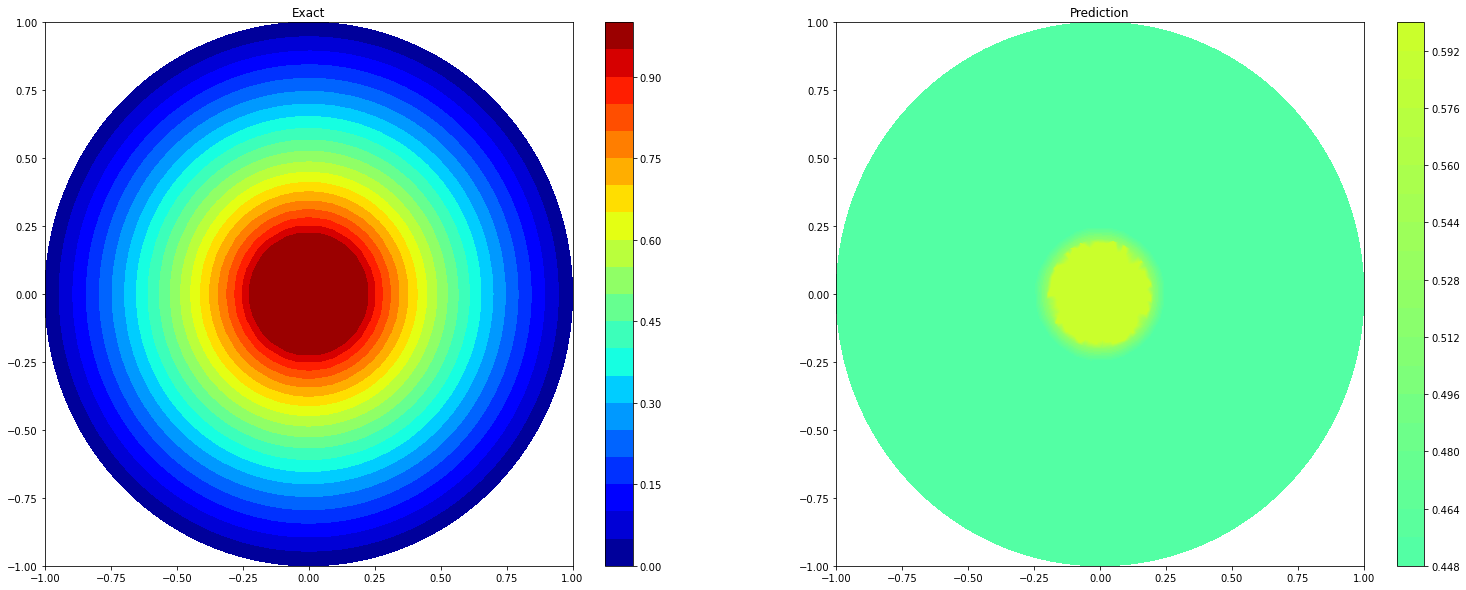

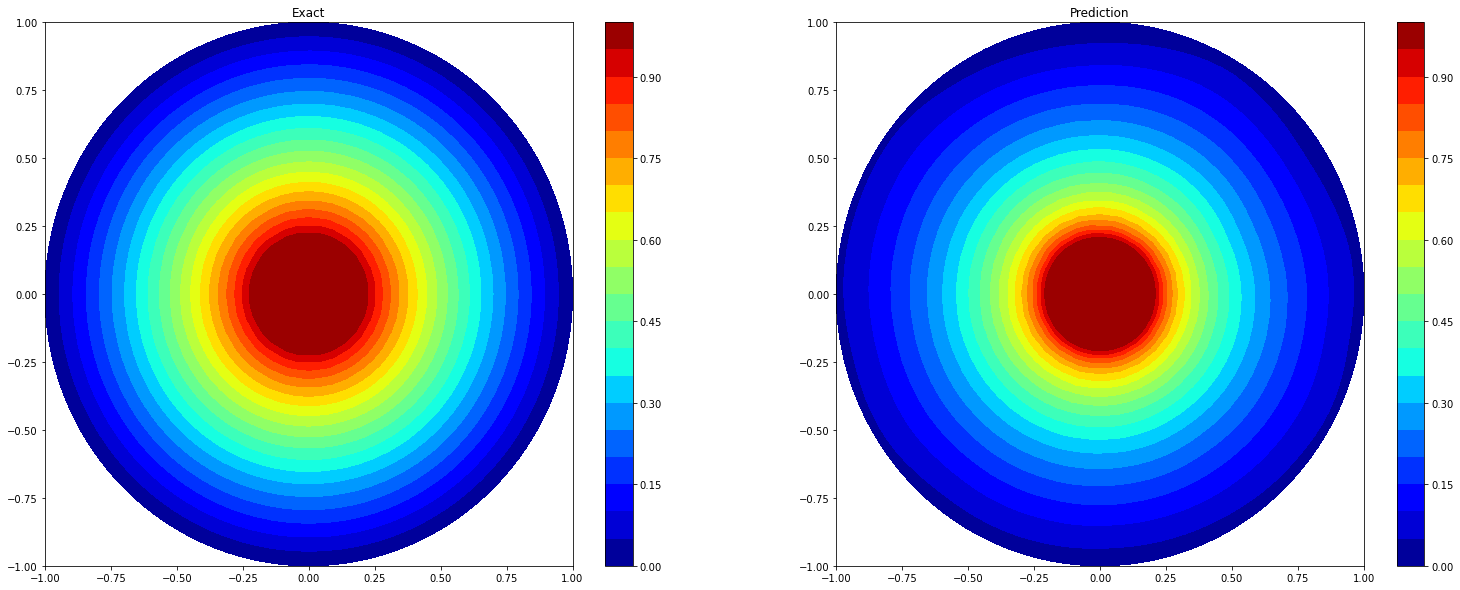

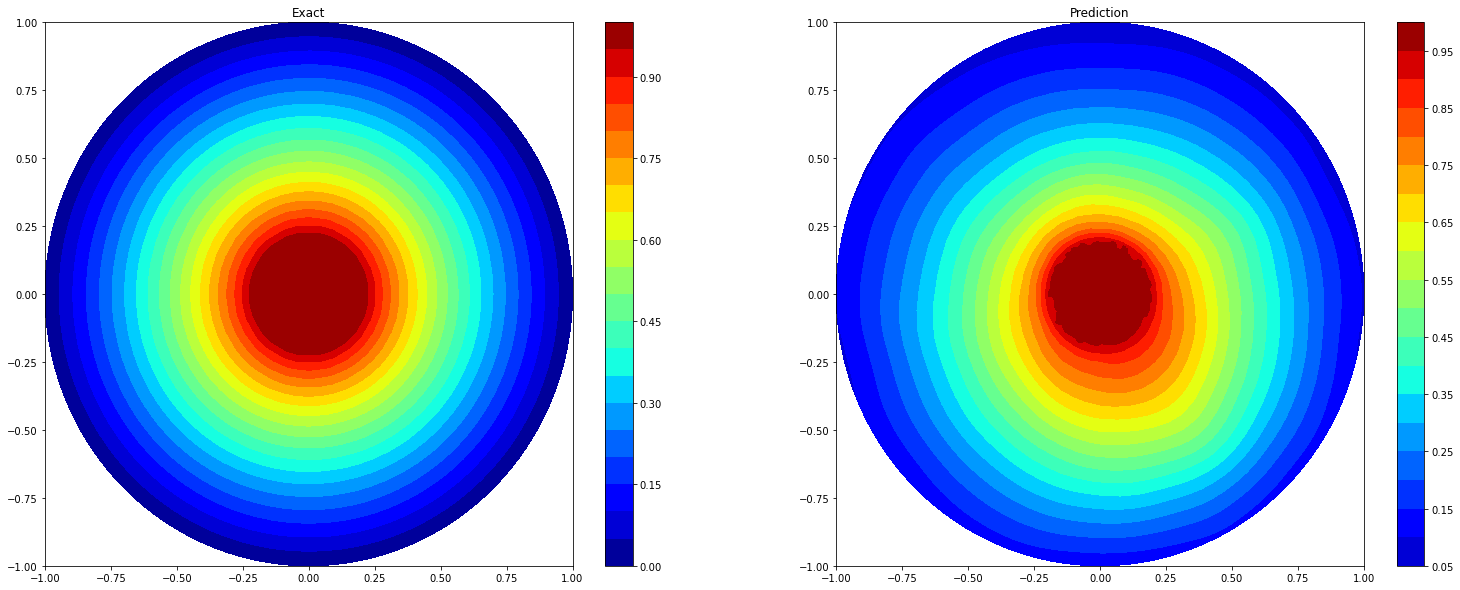

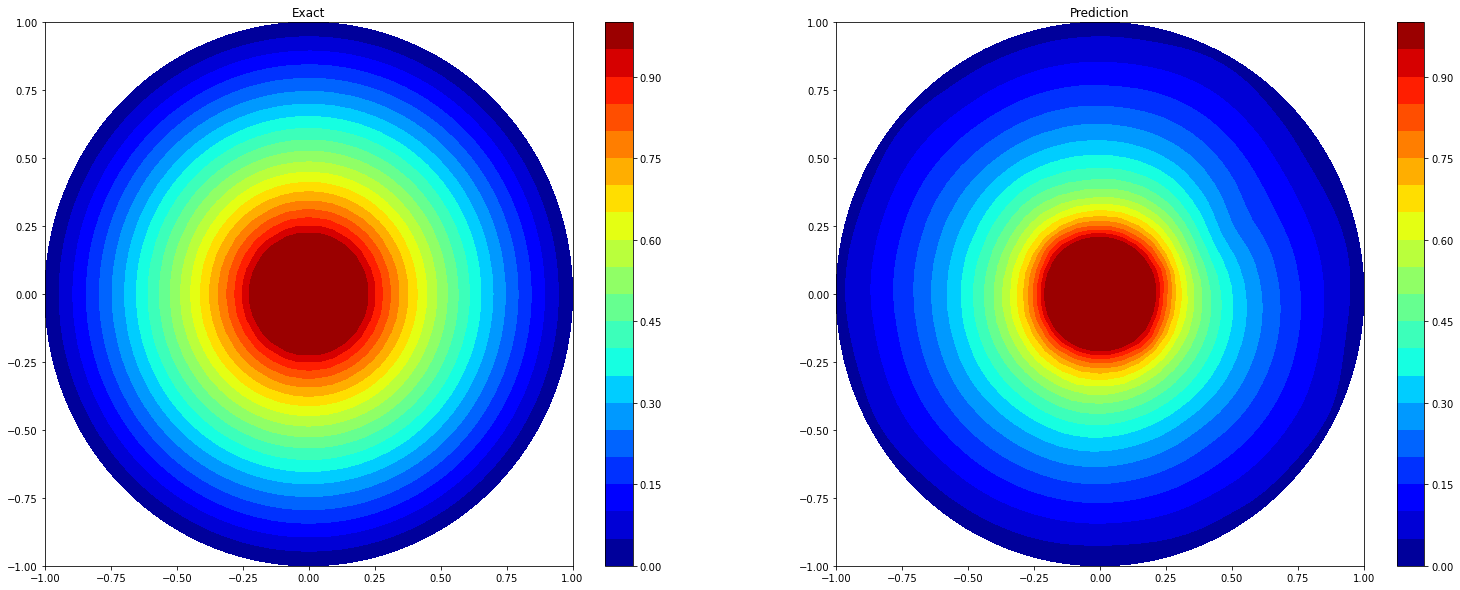

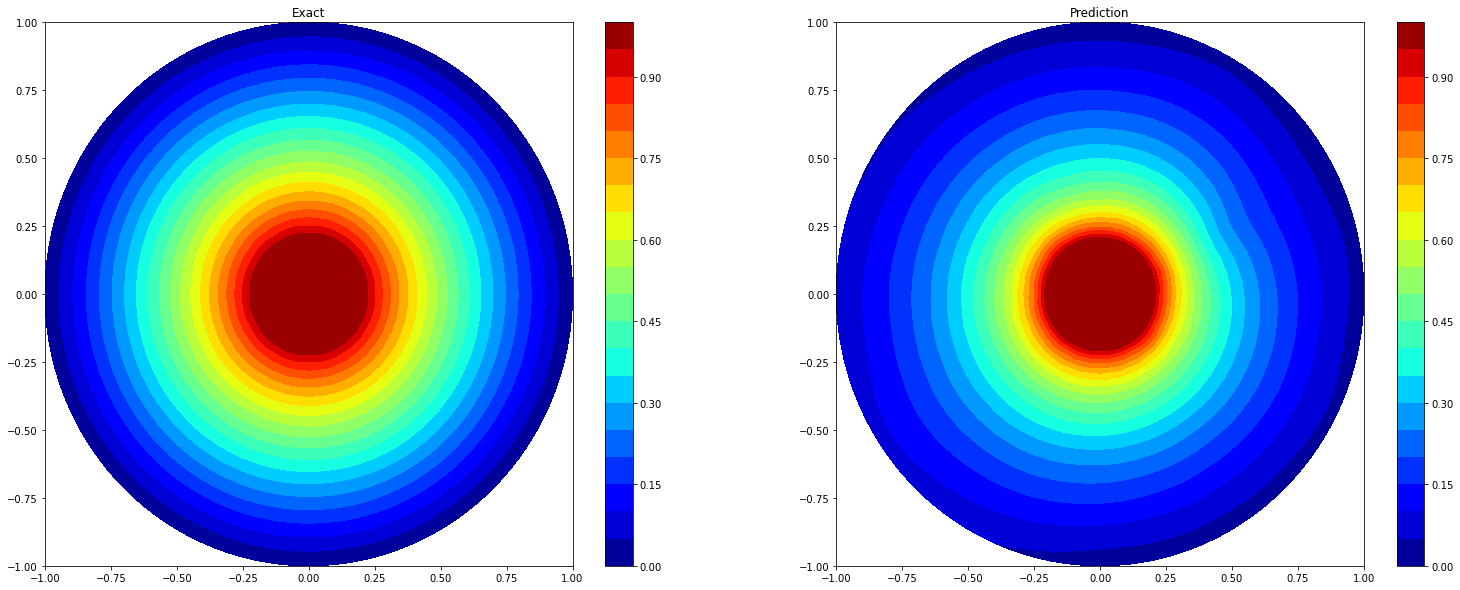

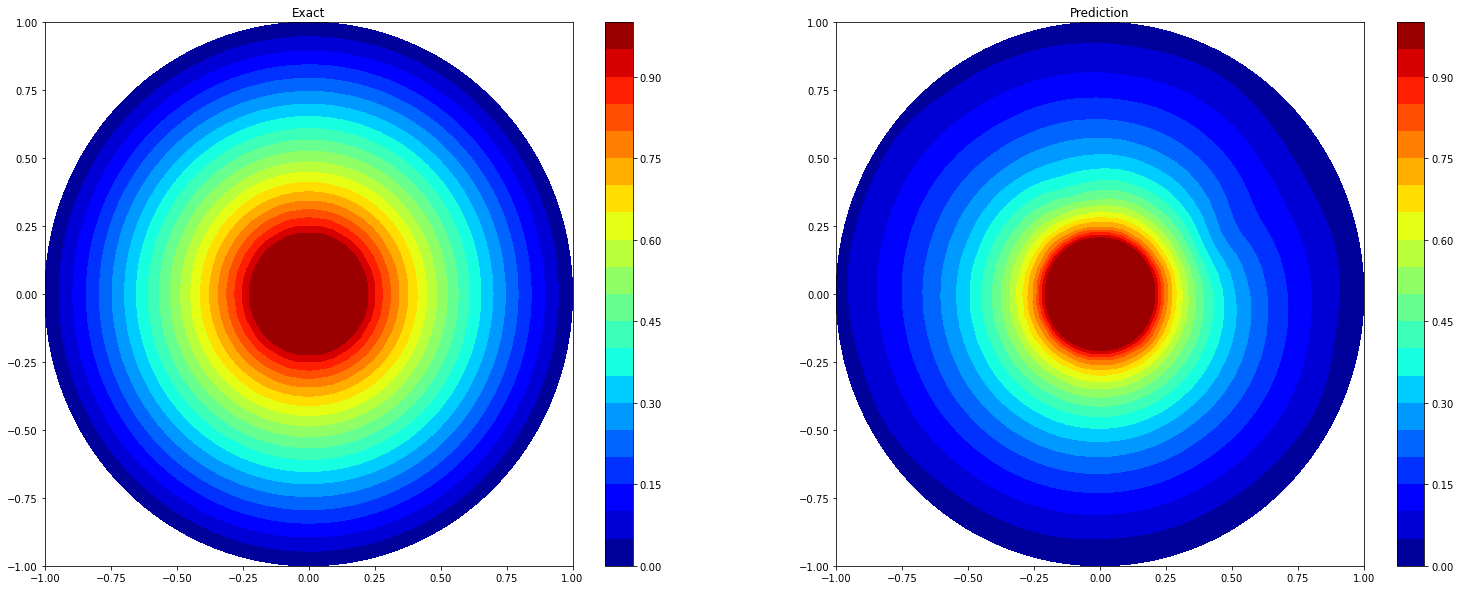

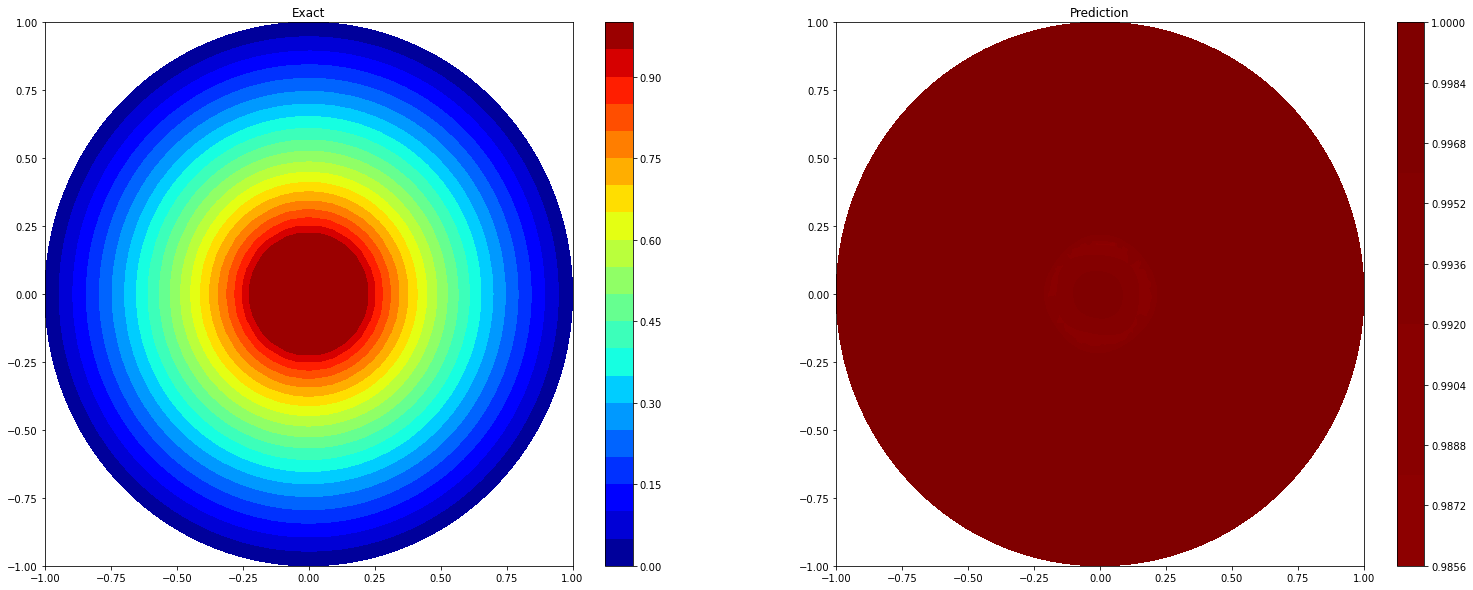

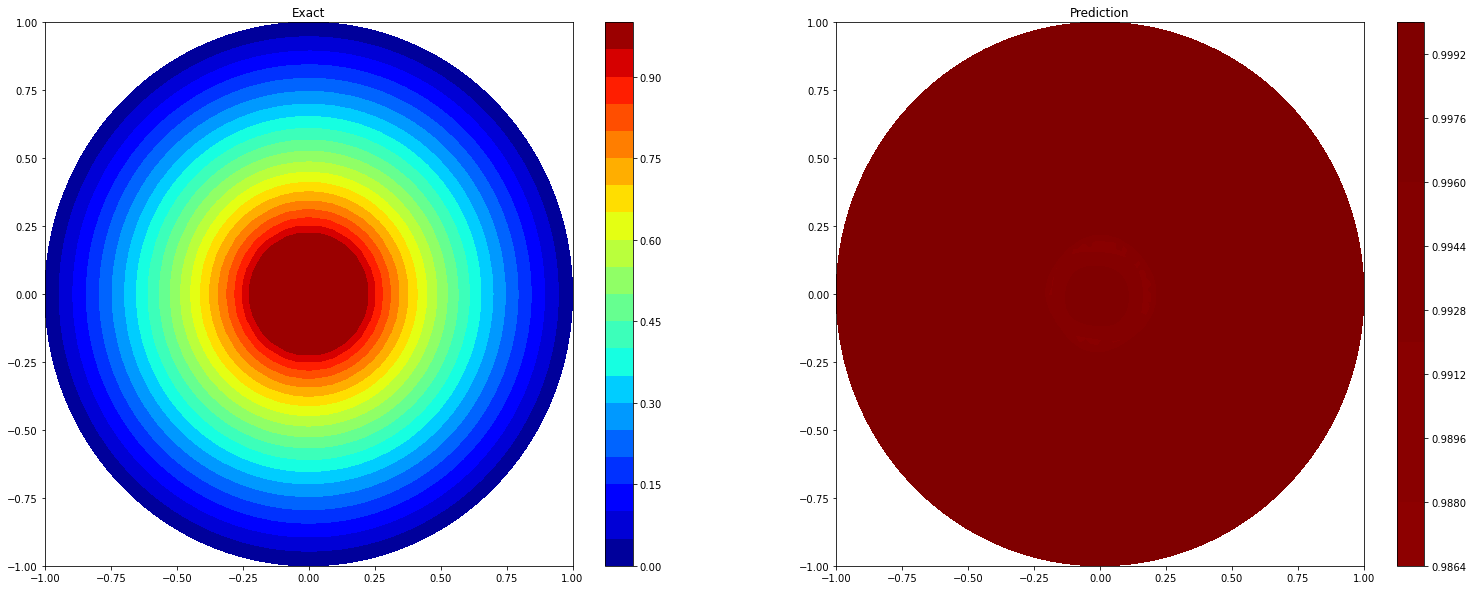

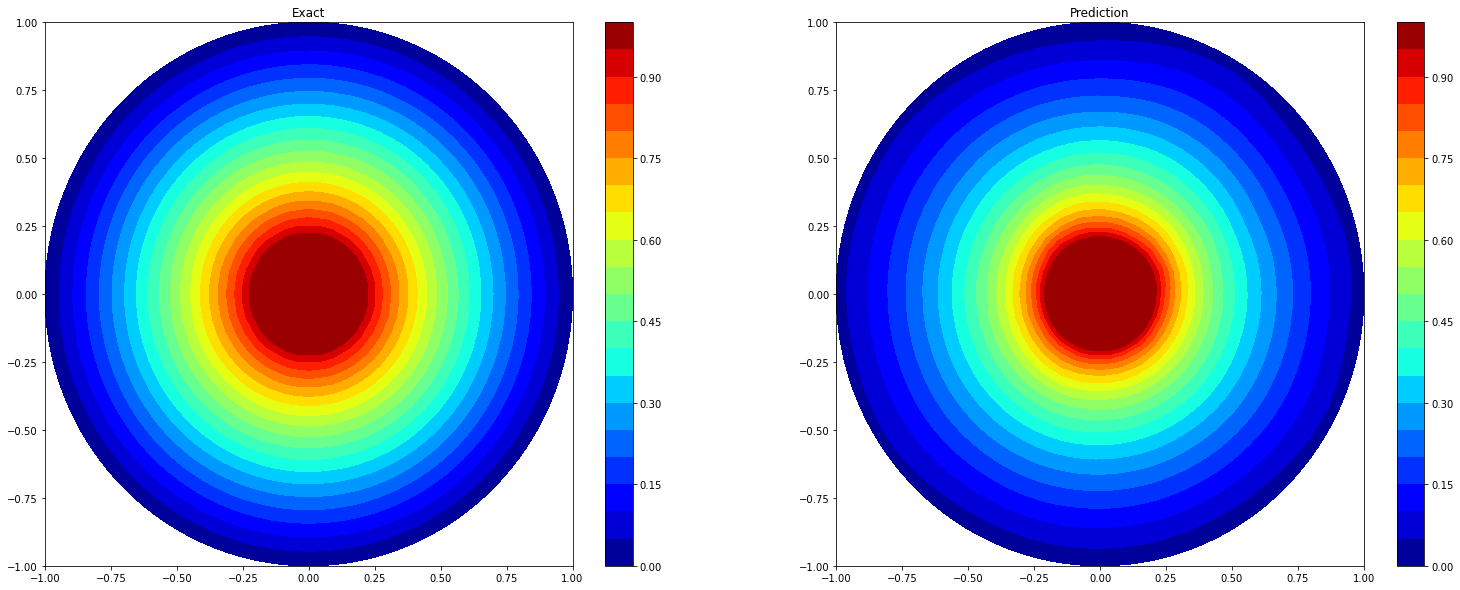

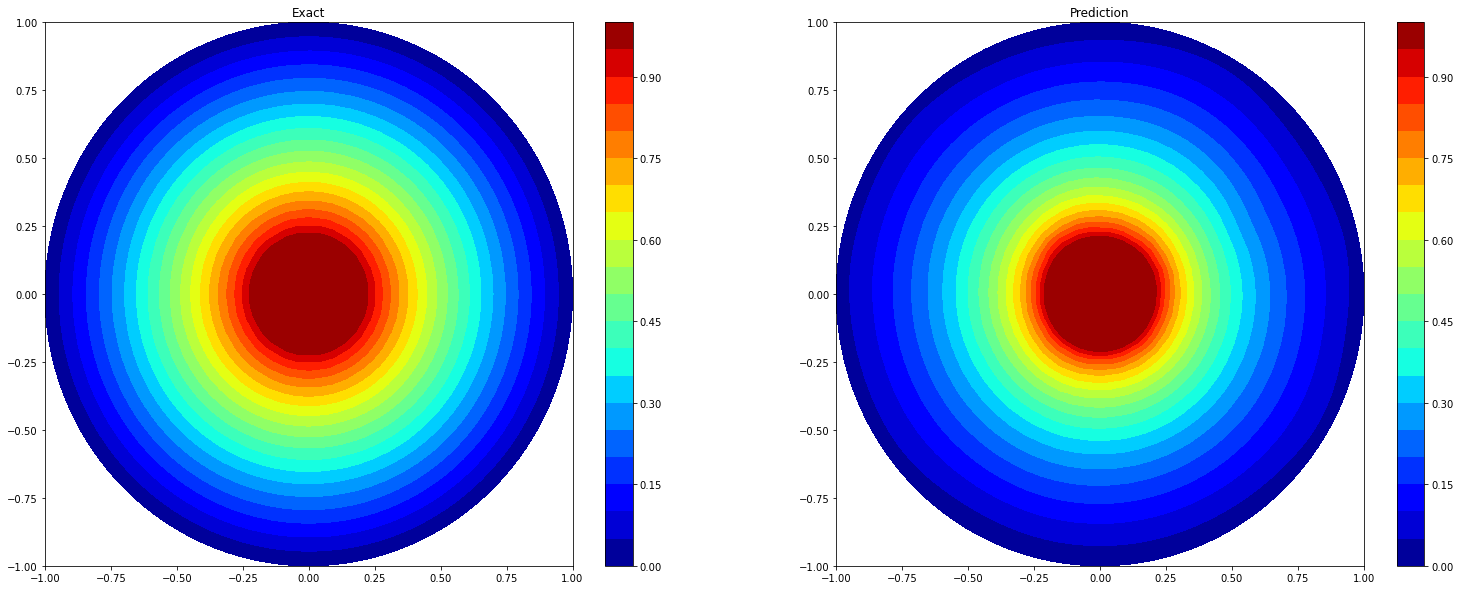

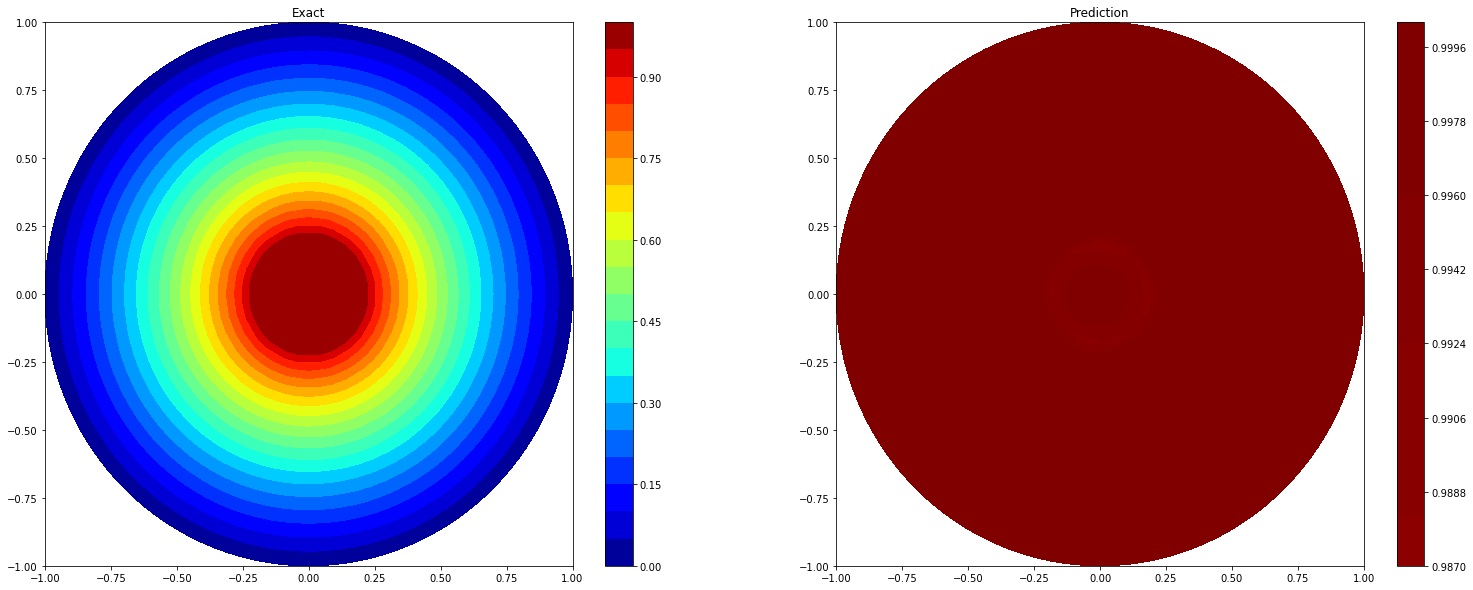

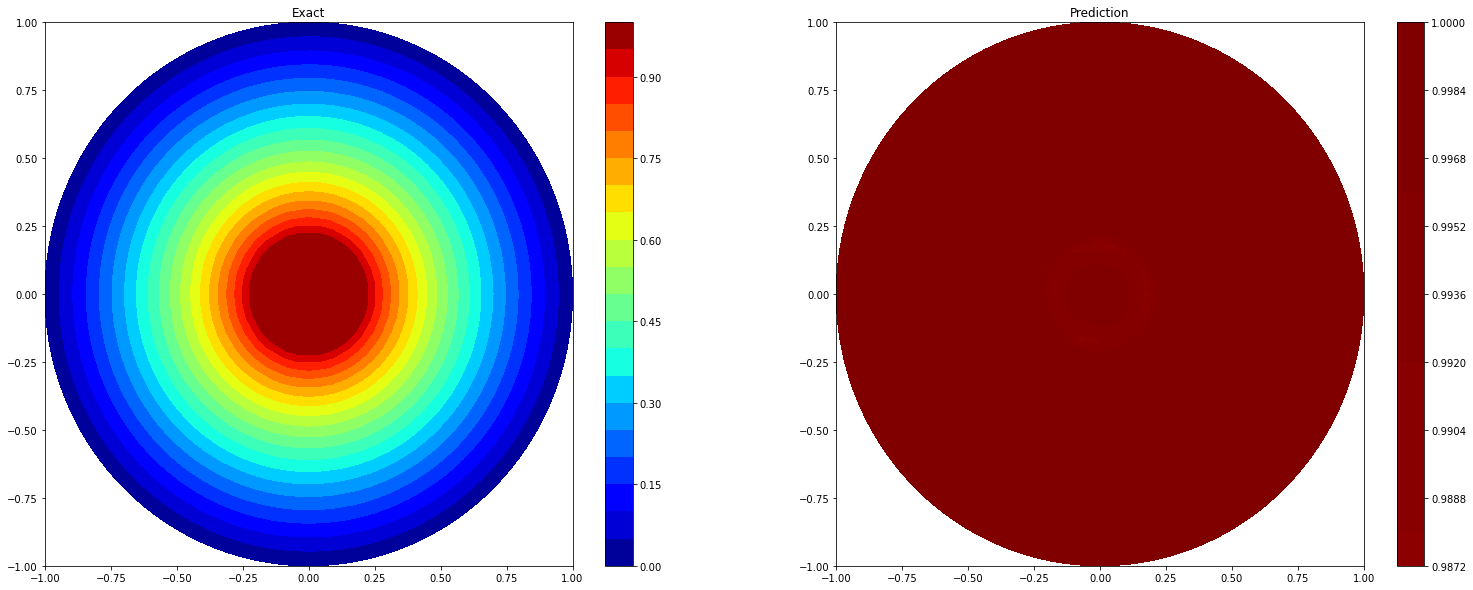

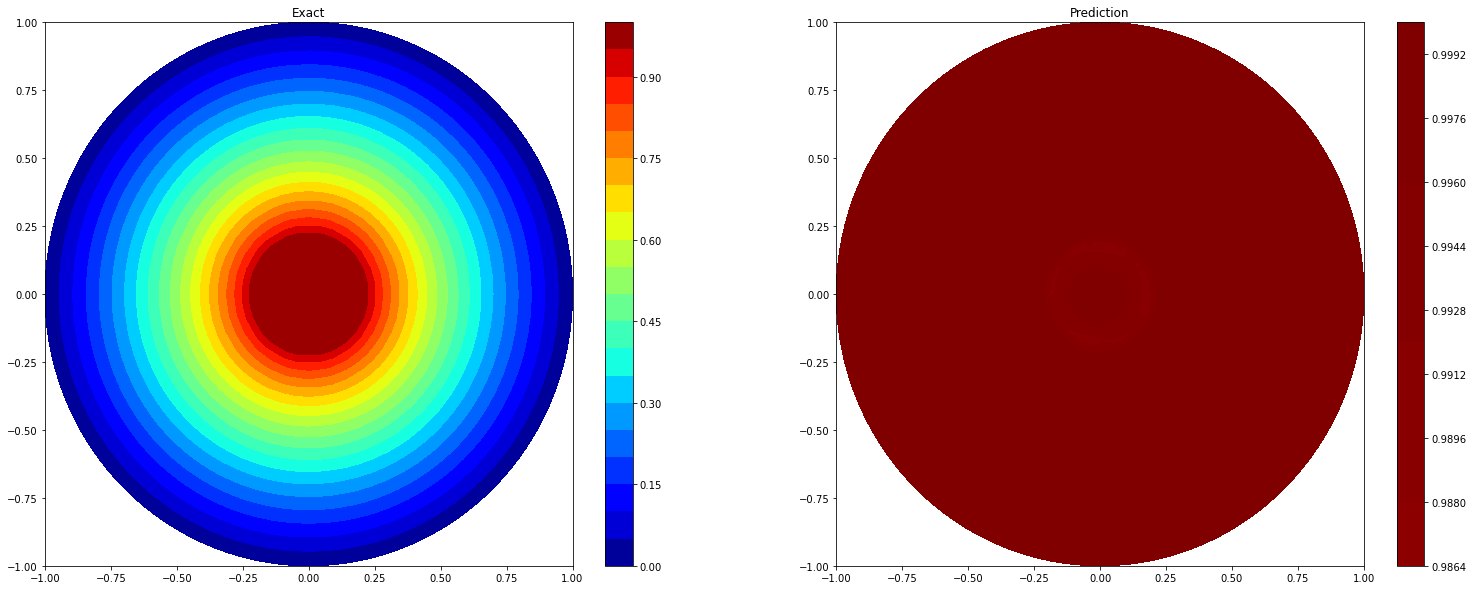

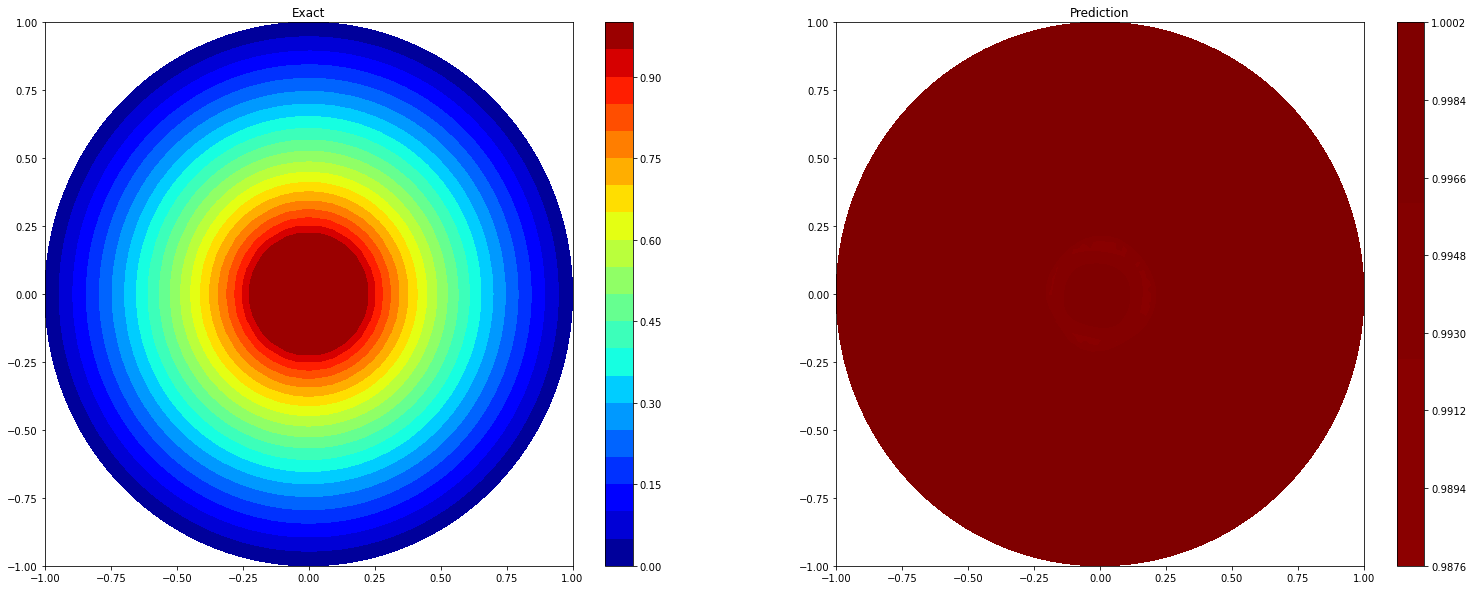

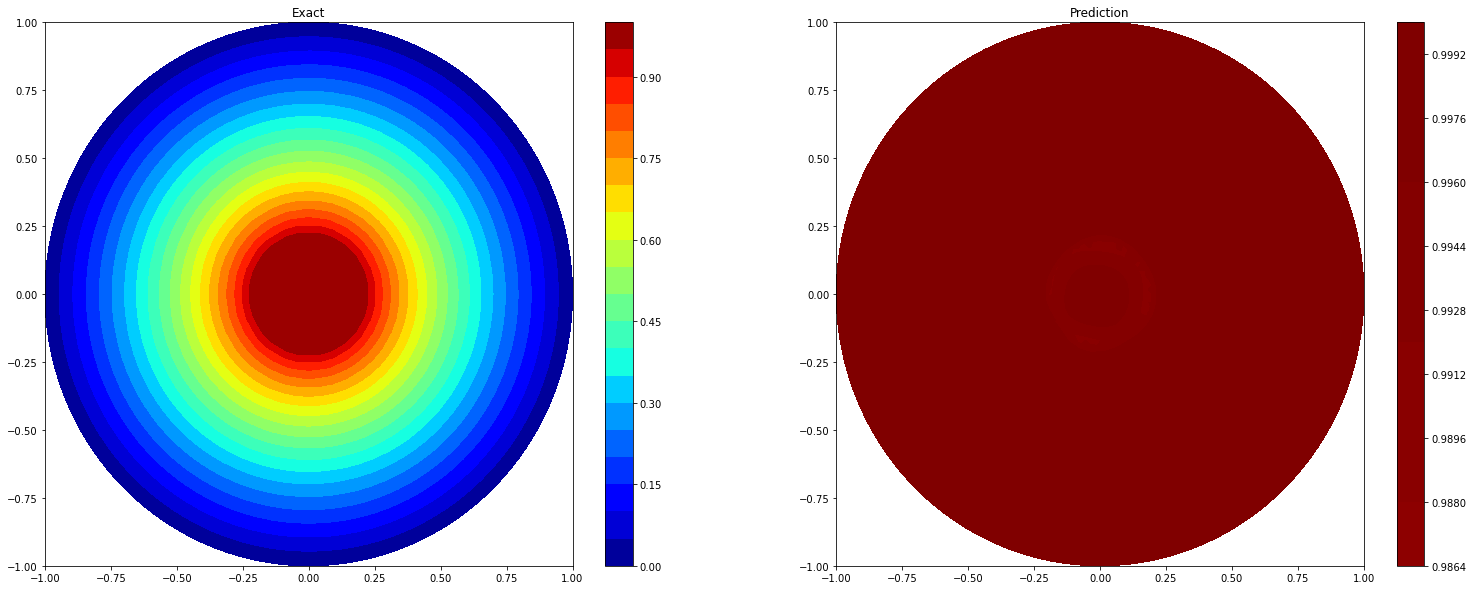

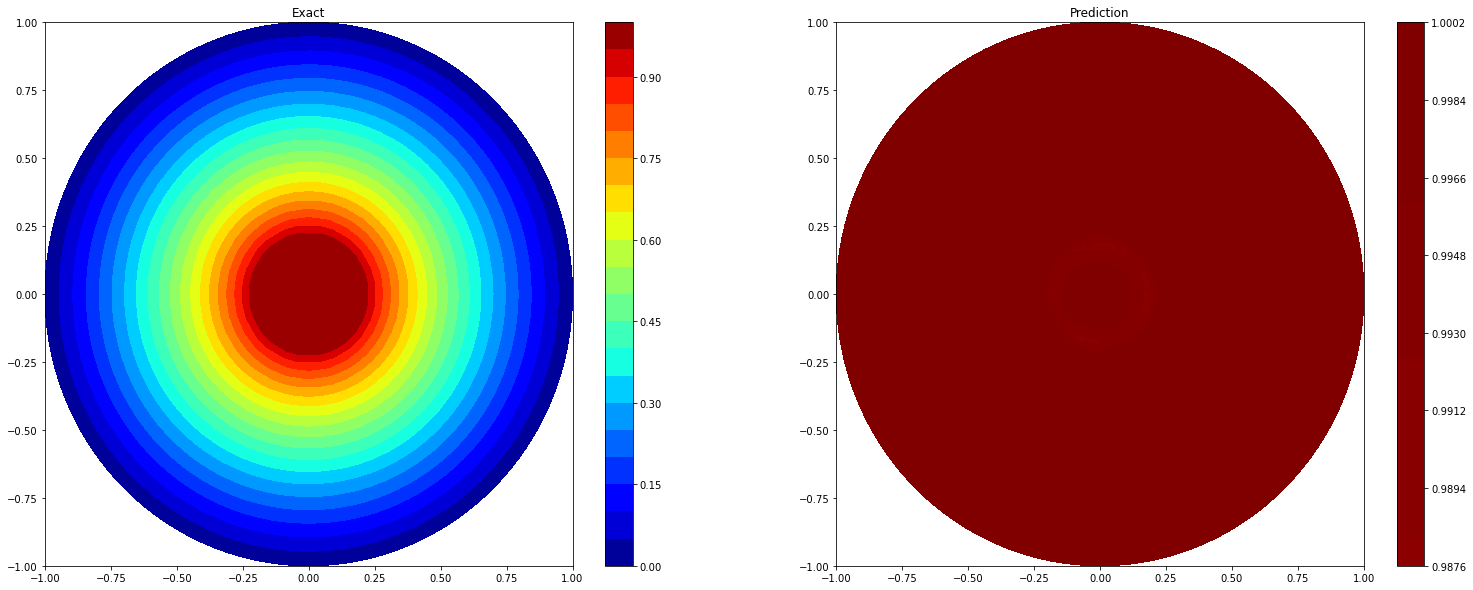

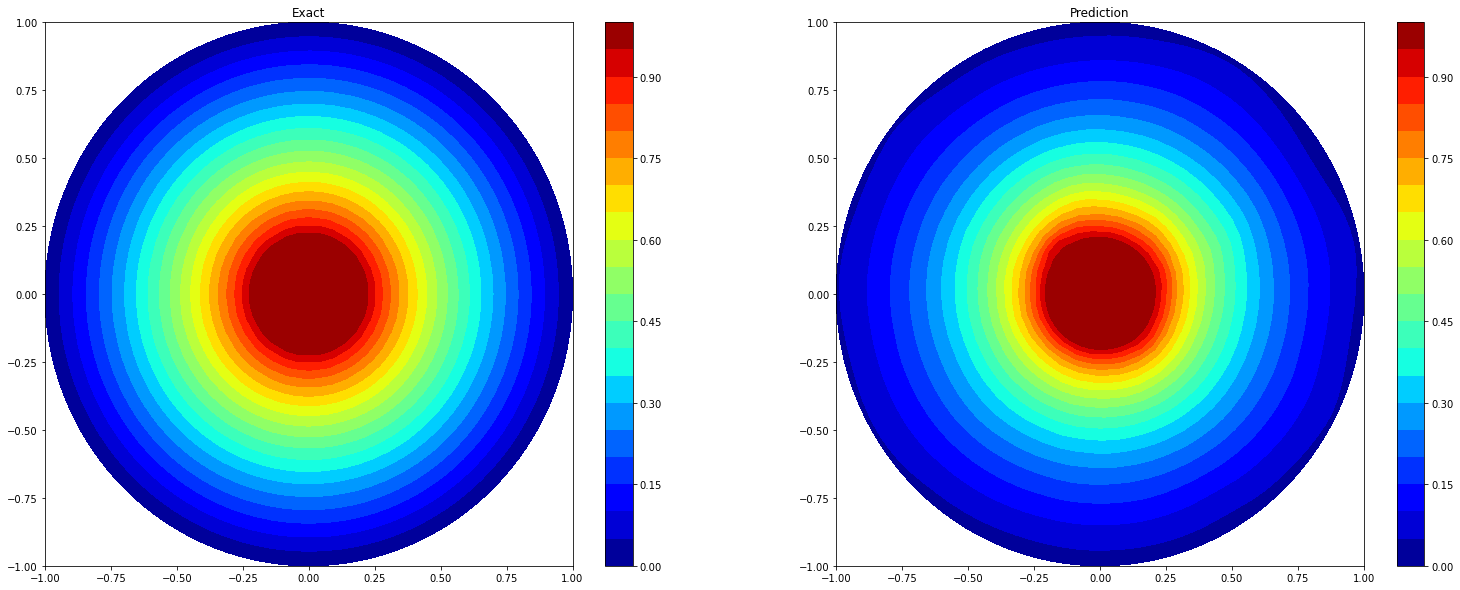

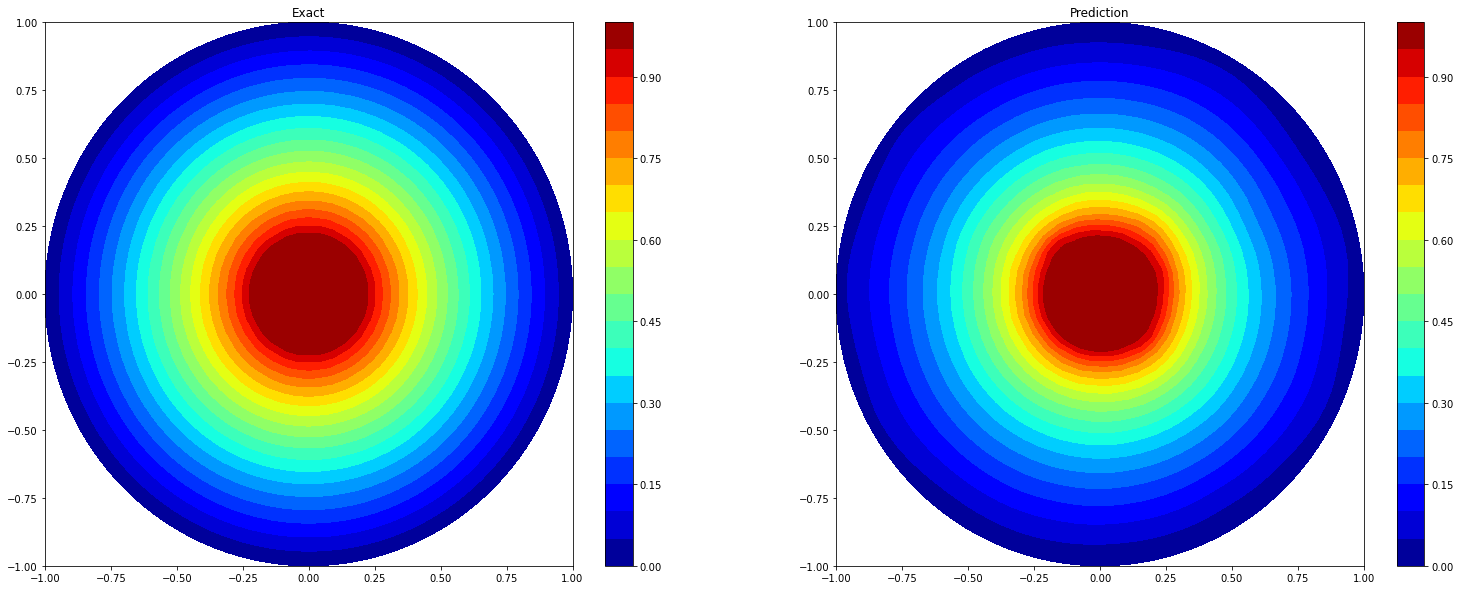

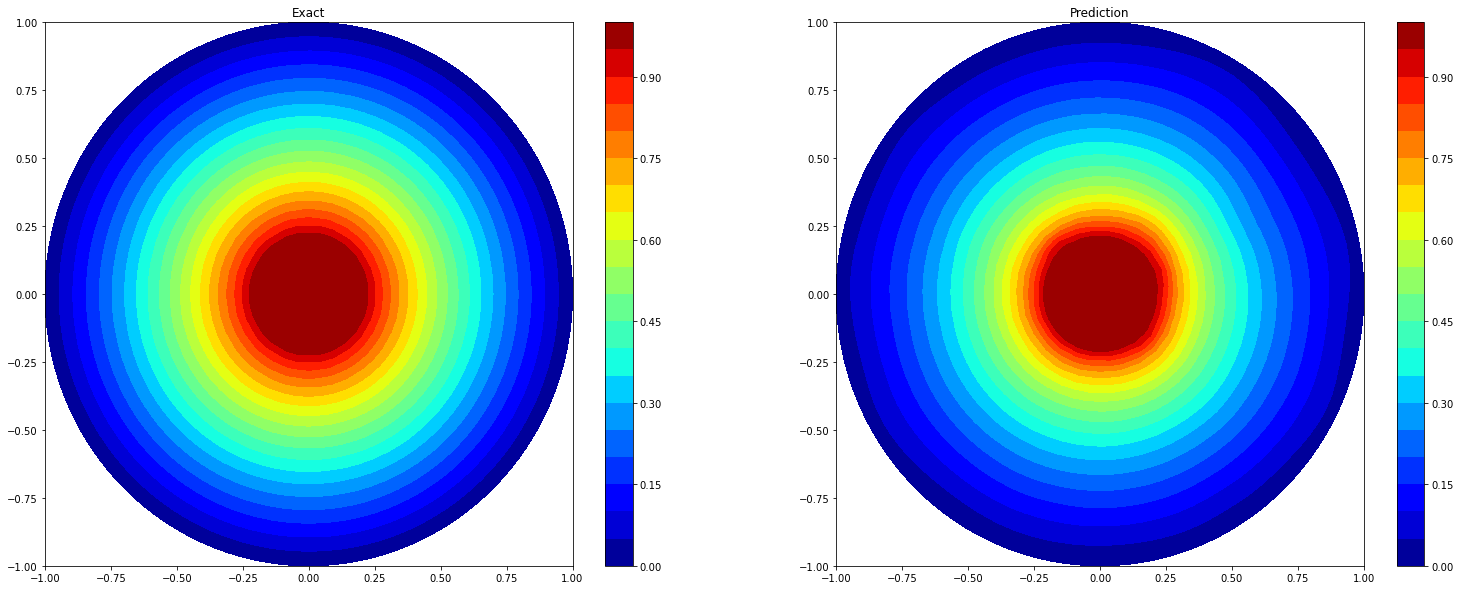

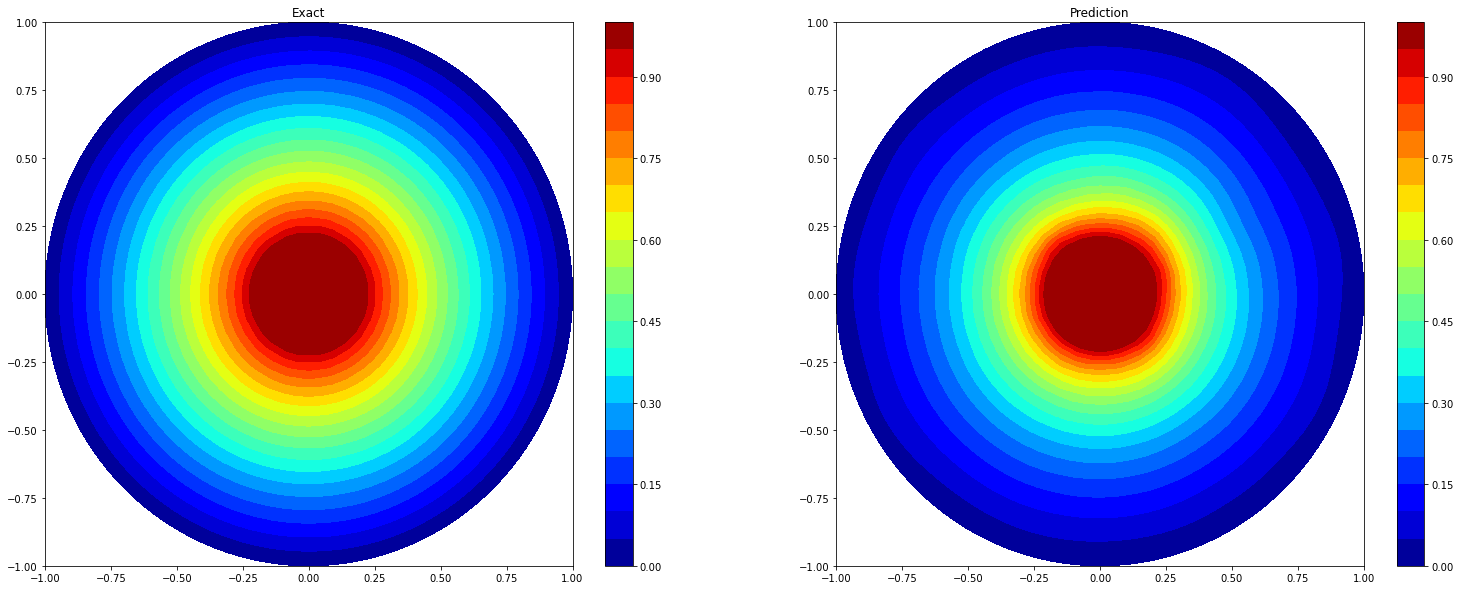

In [5]:
# Hyperparameters
nn_approximator_1 = NNApproximator(4, 400, nn.Sigmoid())
nn_approximator_2 = NNApproximator(3, 300, nn.Sigmoid())

multiplier = 60
lr = 0.0008
max_epochs = 20000

device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"
  if torch.cuda.device_count() > 1:
    nn_approximator_1 = nn.DataParallel(nn_approximator_1)
    nn_approximator_2 = nn.DataParallel(nn_approximator_2)
nn_approximator_1.to(device)
nn_approximator_2.to(device)

x1 = torch.tensor(X_f1_train, requires_grad=True)
x2 = torch.tensor(X_f2_train, requires_grad=True) 
xi = torch.tensor(X_fi_train, requires_grad=True) 
xb = torch.tensor(X_ub_train, requires_grad=True)
u1 = torch.tensor(u_f1_train)
u2 = torch.tensor(u_f1_train)
ub = torch.tensor(ub_train)
ub = torch.zeros_like(ub)
ufi = torch.tensor(u_fi1_train)


x1 = x1.to(device)
x2 = x2.to(device)
xi = xi.to(device)
xb = xb.to(device)
u1 = u1.to(device)
u2 = u2.to(device)
ub = ub.to(device)
ufi = ufi.to(device)

# train the PINN
loss_fn = partial(compute_loss,     
                  x1 = x1, 
                  x2 = x2, 
                  xi = xi, 
                  xb = xb, 
                  ub = ub,
                  ufi = ufi,
                  u1 = u1,
                  u2 = u2,
                  mult = multiplier,
                  verbose=True)

nn_approximator_trained, loss_evolutions, loss_array = train_model(
                                                                  nn_approximator_1,
                                                                  nn_approximator_2,
                                                                  loss_fn=loss_fn, 
                                                                  learning_rate=lr, 
                                                                  max_epochs=max_epochs
                                                                )

print("Finished Training")

# Plotting loss graphs

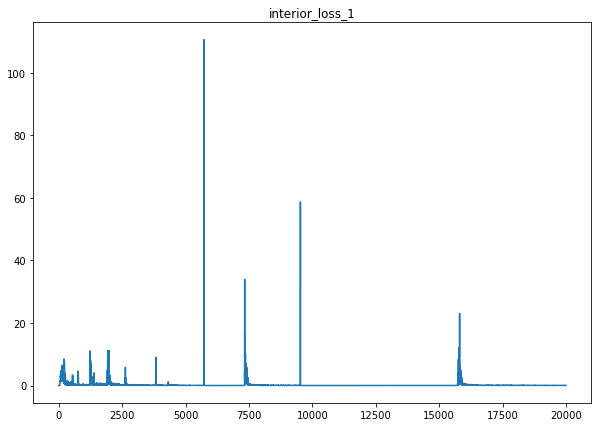

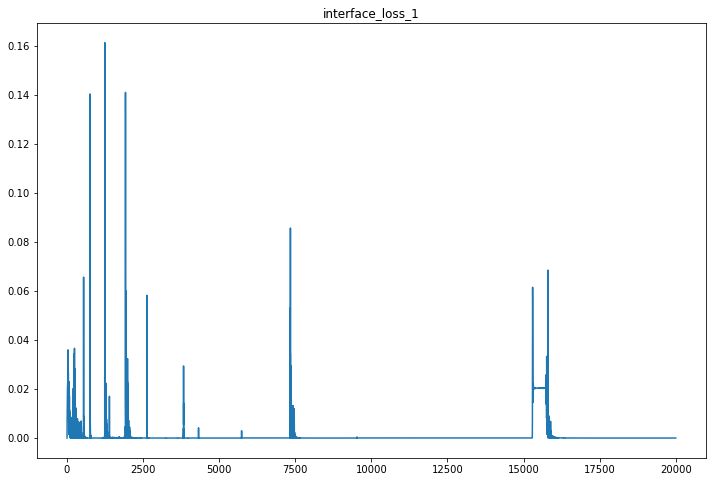

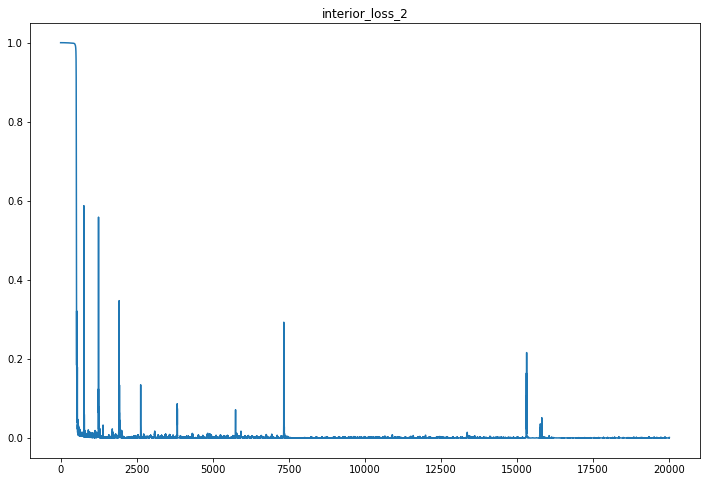

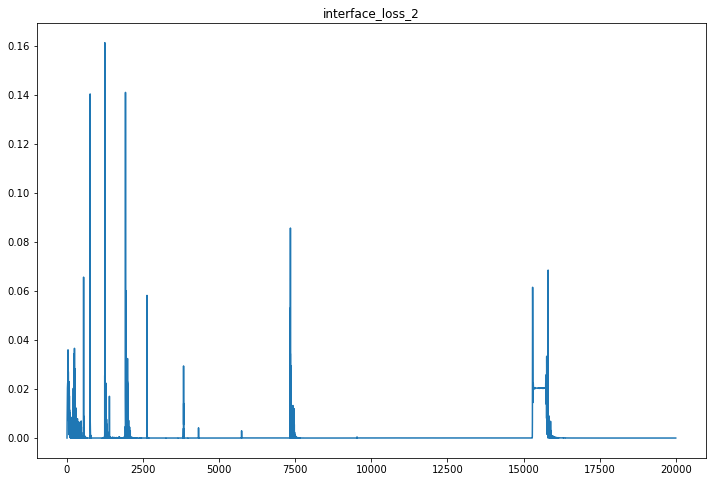

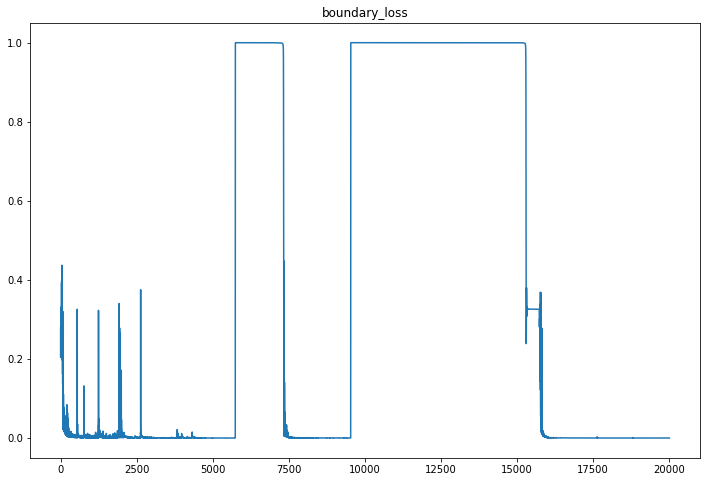

In [6]:
fig = plt.figure(figsize=(10, 7))

plt.plot(loss_array[0, :])
plt.title('interior_loss_1')
plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[1, :])
plt.title('interface_loss_1')
plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[2, :])
plt.title('interior_loss_2')
plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[3, :])
plt.title('interface_loss_2')

plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[4, :])
plt.title('boundary_loss')

plt.show()

# Making Predictions

In [7]:
# Solution prediction
nn1_trained = nn_approximator_trained[0]
nn2_trained = nn_approximator_trained[1]

device = torch.device("cpu")
nn1_trained.to(device)
nn2_trained.to(device)
print("After moving to CPU: ", next(nn1_trained.parameters()).is_cuda)

u_pred1 = nn1_trained(torch.tensor(np.float32(X_f1))).detach().cpu().numpy()
u_pred2 = nn2_trained(torch.tensor(np.float32(X_f2))).detach().cpu().numpy()

u_pred_i1 = nn1_trained(torch.tensor(np.float32(X_fi))).detach().cpu().numpy()
u_pred_i2 = nn2_trained(torch.tensor(np.float32(X_fi))).detach().cpu().numpy()

u_pred_b = nn1_trained(torch.tensor(np.float32(X_ub))).detach().numpy()

u_pred = np.concatenate([u_pred1, u_pred2, (u_pred_i1 + u_pred_i2)/2, u_pred_b])

After moving to CPU:  False


In [21]:
%%timeit
u_pred1 = nn1_trained(torch.tensor(np.float32(X_f1))).detach().cpu().numpy()
u_pred_i1 = nn1_trained(torch.tensor(np.float32(X_fi))).detach().cpu().numpy()
u_pred_b = nn1_trained(torch.tensor(np.float32(X_ub))).detach().numpy()

35.9 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
u_pred2 = nn2_trained(torch.tensor(np.float32(X_f2))).detach().cpu().numpy()
# u_pred_i2 = nn2_trained(torch.tensor(np.float32(X_fi))).detach().cpu().numpy()

5.89 ms ± 84.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Plotting Contours

(2693, 1) (2693, 1) (2693, 1) (2693, 1)


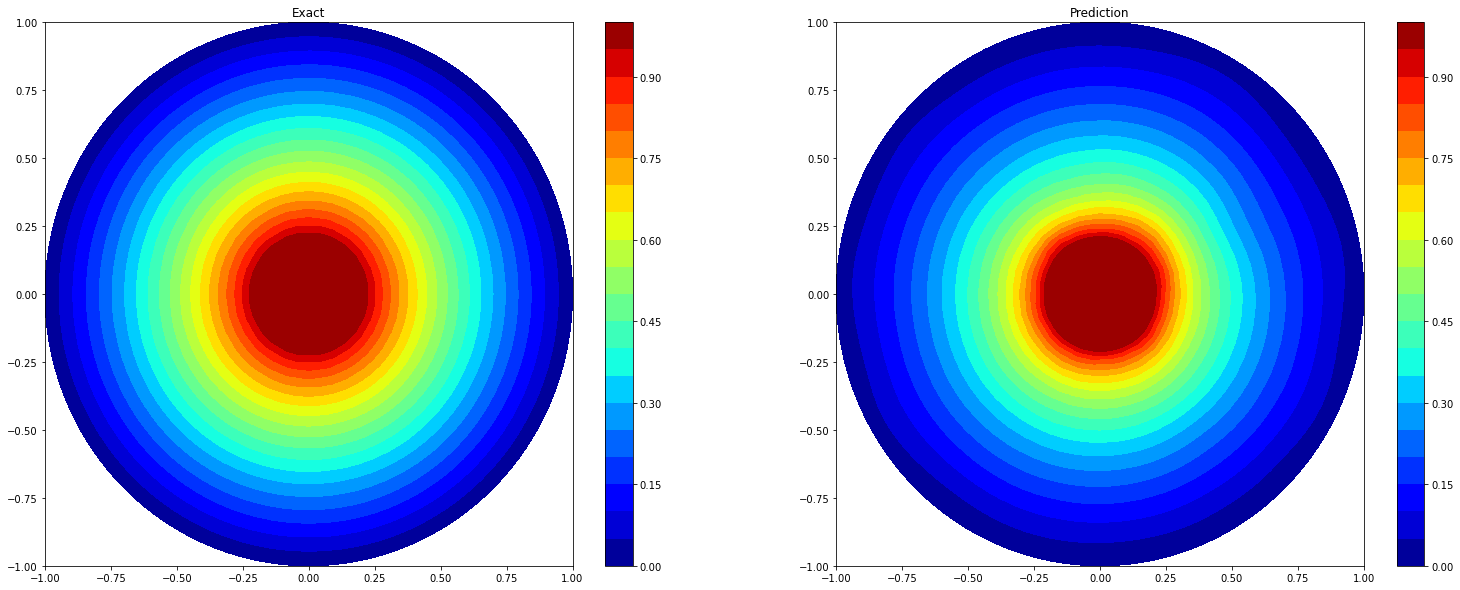

In [16]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

x_tot = np.concatenate([x_f1, x_f2, x_i, x_boundary])
y_tot = np.concatenate([y_f1, y_f2, y_i, y_boundary])
print(x_tot.shape, y_tot.shape, u_pred.shape, u_exact.shape)

np.random.seed(19680801)
npts = 200
ngridx = 100
ngridy = 200
x = x_tot.squeeze()
y = y_tot.squeeze()
up = u_pred.squeeze()
uex = u_exact.squeeze()/u_exact.max()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(26,10))
vmin=0
vmax=2.2

## True Exact
# ax2.tricontour(x, y, z, levels=20, linewidths=0.5, colors='k')
cntr1 = ax1.tricontourf(x, y, uex, levels=20, vmin=0, vmax=1, cmap="jet")

fig.colorbar(cntr1, ax=ax1)
# ax2.plot(x, y, 'ko', ms=3)
ax1.set(xlim=(-1, 1), ylim=(-1, 1))
ax1.set_title('Exact')


## Predictions
# ax2.tricontour(x, y, z, levels=20, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, up, levels=20, vmin=0, vmax=1, cmap="jet")

fig.colorbar(cntr2, ax=ax2)
# ax2.plot(x, y, 'ko', ms=3)
ax2.set(xlim=(-1, 1), ylim=(-1, 1))
ax2.set_title('Prediction')

plt.subplots_adjust(hspace=0.5)
plt.savefig("Contour_Plots_NL/Epoch_Final" + ".png", dpi = 600)
plt.show()

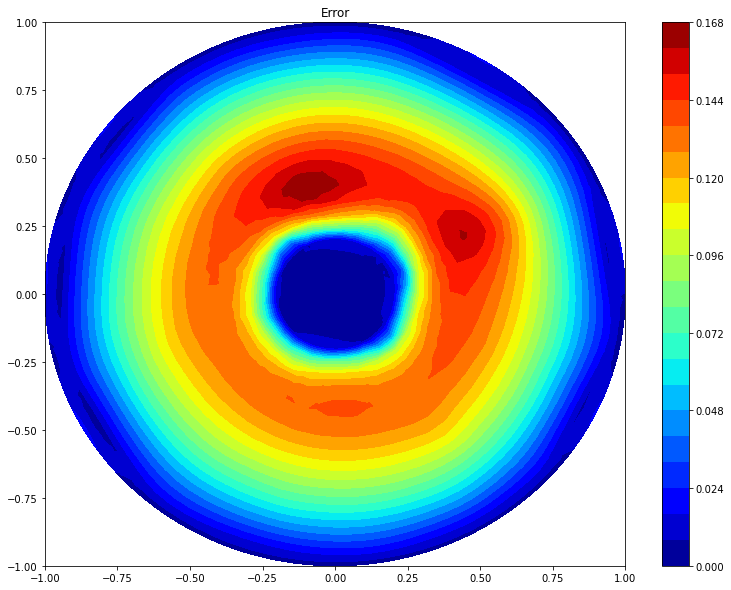

In [18]:
error = abs(uex-up)
fig, ax1 = plt.subplots(1,1,figsize=(13,10))

## True Exact
# ax2.tricontour(x, y, z, levels=20, linewidths=0.5, colors='k')
cntr1 = ax1.tricontourf(x, y, error, levels=20, cmap="jet")

fig.colorbar(cntr1, ax=ax1)
# ax2.plot(x, y, 'ko', ms=3)
ax1.set(xlim=(-1, 1), ylim=(-1, 1))
ax1.set_title('Error')

plt.subplots_adjust(hspace=0.5)
plt.savefig("Contour_Plots_NL/error_points.png", dpi=600)
plt.show()

In [12]:
print(error.mean())

0.03549176600566207


In [13]:
file = open(r'Contour_Plots_NL\Error_Info.txt', 'w')
file.write('Mean = ' + str(error.mean()) + '\nStd = ' + str(error.std()) + '\nMedian = ' + str(np.median(error)) +
          '\nMax = ' + str(error.max()) + '\nMin = ' + str(error.min()))
file.close()

In [23]:
with open(r'Contour_Plots_NL\MSE_Coil_NL.npy', 'wb') as f:
    np.save(f, loss_evolutions)